In [2]:
import fresnel
import gsd.hoomd
import numpy as np
with gsd.hoomd.open(name="prod_traj.gsd", mode="rb") as gsd_file:
    snap = gsd_file[0]

In [3]:
box = snap.configuration.box
N = snap.particles.N
particle_types = snap.particles.typeid
colors = np.empty((N, 3))
# Color by typeid
colors[particle_types == 0] = fresnel.color.linear([.95, 0, 0]) # A type
colors[particle_types == 1] = fresnel.color.linear([0, .95, 0]) # B type

In [4]:
scene = fresnel.Scene()

# Spheres for every particle in the system
geometry = fresnel.geometry.Sphere(scene, N=N, radius=0.2)
geometry.position[:] = snap.particles.position
geometry.material = fresnel.material.Material(roughness=0.9)
geometry.outline_width = 0.05

# use color instead of material.color
geometry.material.primitive_color_mix = 1.0
geometry.color[:] = fresnel.color.linear(colors)

# create box in fresnel
fresnel.geometry.Box(scene, box, box_radius=.07)

In [5]:
all_bonds = np.stack([snap.particles.position[snap.bonds.group[:, 0]],
                      snap.particles.position[snap.bonds.group[:, 1]],],axis=1,)

print(snap.bonds.group)

# Use a distance cutoff (L/2) to filter bonds that span the periodic boundary
bond_distances = np.linalg.norm(all_bonds[:,0,:]-all_bonds[:,1,:], axis=1)

[[     0      1]
 [     1      2]
 [     2      3]
 ...
 [134143 134119]
 [134143 134120]
 [134143 134136]]


In [6]:
# This simple method will work for cubic cells
L = box[0]
bond_indices = np.where(bond_distances < L/2)[0]
filtered_bonds = all_bonds[bond_indices, :, :]

N_bonds = filtered_bonds.shape[0]
bonds = fresnel.geometry.Cylinder(scene, N=N_bonds)
bonds.material = fresnel.material.Material(roughness=0.5)
bonds.outline_width = 0.05

# Color by bond typeid
bond_ids = snap.bonds.typeid[bond_indices]
bond_colors = np.empty((N_bonds, 3))
bond_colors[bond_ids == 0] = fresnel.color.linear([0, .95, 0])  # B-B Bonds
bond_colors[bond_ids == 1] = fresnel.color.linear([0, 0, .95])  # C-C Bonds

bonds.material.primitive_color_mix = 1.0
bonds.points[:] = filtered_bonds

bonds.color[:] = np.stack([fresnel.color.linear(bond_colors), fresnel.color.linear(bond_colors)], axis=1)
bonds.radius[:] = [0.1] * N_bonds

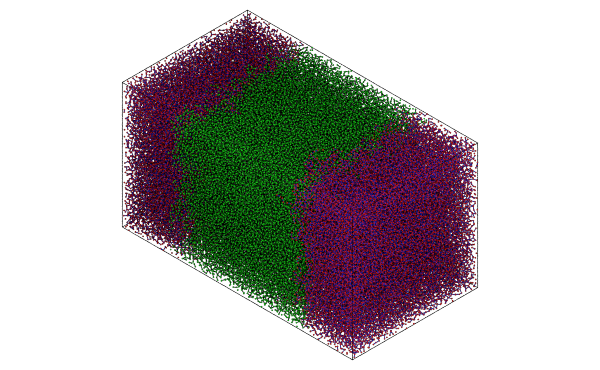

In [7]:
scene.camera = fresnel.camera.Orthographic.fit(scene)
scene.lights = fresnel.light.lightbox()
fresnel.pathtrace(scene, light_samples=5)

In [17]:
traj = gsd.hoomd.open('prod_traj.gsd')

In [22]:
import io
import warnings
import math
import fresnel
import IPython
import numpy
import packaging.version
import PIL

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot, particles=None, is_solid=None):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    vertices = [
        (-0.5, 0, 0),
        (0.5, 0, 0),
        (0, -0.5, 0),
        (0, 0.5, 0),
        (0, 0, -0.5),
        (0, 0, 0.5),
    ]
    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)
    N = snapshot.particles.N
    L = snapshot.configuration.box[0]
    if particles is not None:
        N = len(particles)
    if is_solid is not None:
        N = int(numpy.sum(is_solid))

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(scene, poly_info, N=N)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [0.01, 0.74, 0.26]),
                                                  roughness=0.5)
    if particles is None and is_solid is None:
        geometry.position[:] = snapshot.particles.position[:]
        geometry.orientation[:] = snapshot.particles.orientation[:]
    elif particles is not None:
        geometry.position[:] = snapshot.particles.position[particles, :]
        geometry.orientation[:] = snapshot.particles.orientation[particles, :]
    elif is_solid is not None:
        geometry.position[:] = snapshot.particles.position[numpy.ix_(
            is_solid, [0, 1, 2])]
        geometry.orientation[:] = snapshot.particles.orientation[numpy.ix_(
            is_solid, [0, 1, 2, 3])]

    geometry.outline_width = 0.01
    box = fresnel.geometry.Box(scene,
                               snapshot.configuration.box,
                               box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L * 2, L, L * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return tracer.sample(scene, samples=500)


def render_movie(frames, particles=None, is_solid=None):
    if is_solid is None:
        is_solid = [None] * len(frames)
    a = render(frames[0], particles, is_solid[0])

    im0 = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB').convert(
        "P", palette=PIL.Image.Palette.ADAPTIVE)
    ims = []
    for i, f in enumerate(frames[1:]):
        a = render(f, particles, is_solid[i])
        im = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB')
        im_p = im.quantize(palette=im0)
        ims.append(im_p)

    blank = numpy.ones(shape=(im.height, im.width, 3), dtype=numpy.uint8) * 255
    im = PIL.Image.fromarray(blank, mode='RGB')
    im_p = im.quantize(palette=im0)
    ims.append(im_p)

    f = io.BytesIO()
    im0.save(f, 'gif', save_all=True, append_images=ims, duration=1000, loop=0)

    size = len(f.getbuffer()) / 1024
    if (size > 3000):
        warnings.warn(f"Large GIF: {size} KiB")
    return IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [ ]:
render_movie(traj[0:1000:1], particles=[12, 18])